# 1) Ask
Can we correctly classify income based on the US 1994 Census Data?

# cool-ml-lab: Imcome Classification based on US 1994 Census Data

#2) Acquire
This dataset is sourced from UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Adult

# 3) Process

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN

from rfpimp import *
import pprint
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# url = 'https://raw.githubusercontent.com/nishatparveen21/Income_dataset_ml/master/adult.csv'
url = 'adult.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [10]:
features = list(df.columns[:-1])

In [11]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Train Test split

Since the data is imbalanced, applying the learning of Terence's class, we split train and test data with the same proportion of classes before upsampling just the train dataset later.

In [12]:
def train_test_split_proper(df, splitter):
    "Split data into training and test set with the same proportion of classes"
    df_lower_income = df[df['income']=='<=50K']
    df_higher_income = df[df['income']=='>50K']

    df_train_lower_income, df_test_lower_income = splitter(df_lower_income, test_size=0.2 )
    df_train_higher_income, df_test_higher_income= splitter(df_higher_income, test_size=0.2)

    df_train = pd.concat([df_train_lower_income, df_train_higher_income], axis=0)
    df_test = pd.concat([df_test_lower_income, df_test_higher_income], axis=0)

    x_train, y_train = df_train.iloc[:,:-1], df_train[['income']]
    x_test, y_test = df_test.iloc[:,:-1], df_test[['income']]
    return x_train, y_train, x_test, y_test

In [13]:
x_train, y_train, x_test, y_test = train_test_split_proper(df, train_test_split)

## Data Cleaning

Filling Missing Data

In [14]:
def fill_missing_data(data):
    "Fill missing values in both numeric and categorical feature columns" 
    numeric_features = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
    for col_name in numeric_features:
        numeric_transformer =  SimpleImputer(missing_values=np.nan,strategy='mean')
        data[col_name]=numeric_transformer.fit_transform(data[[col_name]])

    categorical_features = ['workclass','education','marital-status','occupation',
                            'relationship','race','gender','native-country']
    for col_name in categorical_features:
        categorical_transformer = SimpleImputer(missing_values='?',strategy='most_frequent', fill_value='missing')
        data[col_name]=categorical_transformer.fit_transform(data[[col_name]])
    return data

In [15]:
fill_missing_data(x_train)
fill_missing_data(x_test)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
41438,20.0,Private,406641.0,Some-college,10.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,35.0,United-States
22239,59.0,Private,359292.0,1st-4th,2.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,Mexico
3499,33.0,Private,227325.0,Assoc-acdm,12.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,60.0,Scotland
3517,44.0,Private,210525.0,Bachelors,13.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
7801,25.0,Private,207258.0,9th,5.0,Never-married,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27464,40.0,Private,187376.0,Some-college,10.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,60.0,United-States
48344,30.0,Private,176410.0,Assoc-voc,11.0,Married-civ-spouse,Prof-specialty,Own-child,White,Female,7298.0,0.0,16.0,United-States
39741,69.0,Private,230417.0,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,China
42121,46.0,Private,321327.0,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,7298.0,0.0,45.0,United-States


Label Encoding for categorical features

In [16]:
def label_encoding(data):
    categorical_features = ['workclass','education','marital-status','occupation',
                            'relationship','race','gender','native-country']
    for col_name in categorical_features:
        encoder = preprocessing.LabelEncoder() 
        data[col_name] = encoder.fit_transform(data[[col_name]])
    return data

In [17]:
label_encoding(x_train)
label_encoding(x_test)
encoder = preprocessing.LabelEncoder() 
y_test = encoder.fit_transform(y_test)
y_train = encoder.fit_transform(y_train)

Resampling the minor class

In [18]:
rebalance_instance = ADASYN(random_state=22) 
x_train, y_train = rebalance_instance.fit_resample(x_train, y_train)

### Summary for Data cleaning: 
Data Processing: Split the train and test data by 80:20, fill missing data with mode ( for categorical ones) or with a mean( for numeric ones) and label encodes categorical features. Deal with an imbalanced train set with upsampling.

## Model

>Create a pipeline for each of the following algorithms:
1. Logistic Regression
2. Decision Tree
3. Random Forest™ 

In [19]:
def make_pipelines():
    pipe_lr = Pipeline([('scl', StandardScaler()),
                        ('lr', LogisticRegression(solver='lbfgs', random_state=42))])
    
    pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=42))])
    
    pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=42))])
    
    pipelines = [pipe_lr, pipe_dt, pipe_rf]
    
    return pipelines

In [20]:
pipelines = make_pipelines()
for pipe in pipelines:
    pipe.fit(x_train, y_train)

## Model Evaluation

Cross Validation

In [21]:
def cv_models(pipeline, X_data, y_data, metric):
    for pipe in pipeline:
        scores = cross_validate(pipe, X_data, y_data, cv=10, scoring=metric)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        score = scores['test_score'].mean()
        print(f'For {name}: %.2f' % score)

In [22]:
print('Precision:')
cv_models(pipelines, x_train, y_train, 'precision')

Precision:
For LogisticRegression: 0.75
For DecisionTreeClassifier: 0.86
For RandomForestClassifier: 0.91


In [23]:
print('Recall:')
cv_models(pipelines, x_train, y_train, 'recall')

Recall:
For LogisticRegression: 0.78
For DecisionTreeClassifier: 0.85
For RandomForestClassifier: 0.85


In [24]:
print('F1 weighted score:')
cv_models(pipelines, x_train, y_train, 'f1_weighted')

F1 weighted score:
For LogisticRegression: 0.76
For DecisionTreeClassifier: 0.86
For RandomForestClassifier: 0.88


Confusion Matrix

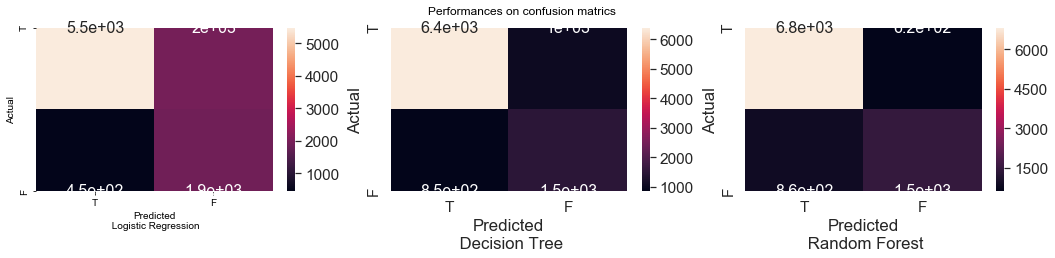

In [25]:
confusion_matrixs = []
plt.figure(figsize=(18, 3))
plt.suptitle('Performances on confusion matrics')
count = 0
x_labels = ['Predicted\n Logistic Regression','Predicted\n Decision Tree','Predicted\n Random Forest']
for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    y_pred = pipe.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrixs.append(cm)
    plt.subplot(131+count)
    df_cm = pd.DataFrame(confusion_matrixs[count],['T','F'], ['T','F'])
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.xlabel(x_labels[count])
    plt.ylabel('Actual')
    count +=1 
plt.show()

Classification Report

In [26]:
for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    y_pred = pipe.predict(x_test)
    print(name)
    print(classification_report(y_test, y_pred))

LogisticRegression
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      7431
           1       0.49      0.81      0.61      2338

    accuracy                           0.75      9769
   macro avg       0.71      0.77      0.72      9769
weighted avg       0.82      0.75      0.77      9769

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7431
           1       0.59      0.64      0.61      2338

    accuracy                           0.81      9769
   macro avg       0.73      0.75      0.74      9769
weighted avg       0.81      0.81      0.81      9769

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7431
           1       0.71      0.63      0.67      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted 

### Modeling and evaluation: 
1. Fit the data with logistic regression, decision tree, and random forest.
2. Used multiple evaluation metrics including accuracy, recall, precision, and R2 score. 
3. Choose a random forest as the best model based on weighted F1 score as an evaluation method.

## Random Search for hyper parameter tuning the best model for the chosen dataset: Random Forest Classifier

In [27]:
cv=5
n_iter=20

def make_random_cv():

    random_params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [ 2, 4, 6, 8, 10],
    'n_estimators': [100, 200, 300]
    }
    
    clf_random_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                              random_params,
                              cv=cv,
                              n_iter=n_iter,
                              n_jobs=-1,
                              verbose=1)    
    return clf_random_cv


clf = make_random_cv()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(clf.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [28]:
def report(y_true, y_pred):
    print("We choose weighted F1 score for our project as the income dataset is imbalanced")
    print(f"{f1_score(y_true, y_pred, average='weighted'):.4f} F1 score.")
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred)) 

In [30]:
report(y_test, y_pred)

We choose weighted F1 score for our project as the income dataset is imbalanced
0.8591 F1 score.
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      7431
           1       0.71      0.69      0.70      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.80      0.81      9769
weighted avg       0.86      0.86      0.86      9769

[[6784  647]
 [ 722 1616]]


# 5) Deliver

### Evaluation Metric: 
F1 Score is a better measure to use if we need to seek a balance between Precision and Recall, 
as there is an uneven class distribution (a large number of Actual Negatives). In our dataset, actual negative are people with income <=50K.
In 1994, very few people were earning >50K so we want both precision(true positive/ predicted positive) and recall(true positive/total actual positive) to classify higher-income people.


Feature Importances

In [31]:
x_train_todf = pd.DataFrame(data=x_train, index=x_train[0:,0], 
                            columns=features)
y_train_todf = pd.DataFrame(data=y_train, index=y_train[0:], columns=['income'])

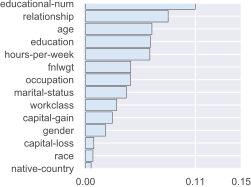

In [32]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf.fit(x_train_todf, y_train_todf)
I = importances(rf, x_train_todf, y_train_todf)
plot_importances(I.head(20))

Interpret the model:
>Education seems to matter the most, which makes sense in real life. The more educated someone gets, the more money he/she earns. The other important factors also include relationship, age, working hours per week. This matches the real-life situation so our model makes sense. Capital-loss, race and native country are the least important features. The capital-loss has some correlation with capital-gain, so this may be the reason it shows less importance. Also, education-num column is label encoded column for column named education.

Takeaway:
>It’s important to balance data. Upsampling works better than downsampling.\
Feature engineering matters because some feature columns can affect the model in a negative!\
Logistic regression can usually serve as a baseline for other models.\
Grid search can present the best hyperparameters but it is super slow.\
Random search works much better than a grid search in terms of the speed at a little cost of the model performance.
